<a href="https://colab.research.google.com/github/agusrdlv/diplodatos_iaa/blob/master/Lab_2_G2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [1]:
#Libs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from seaborn import heatmap
from scipy import stats

#Separación
from sklearn.model_selection import train_test_split

#Gradiente Descendente
from sklearn.linear_model import SGDClassifier

#Árbol de Decisión
from sklearn.tree import (DecisionTreeClassifier, plot_tree)

#Validación Cruzada de HP en grilla.
from sklearn.model_selection import GridSearchCV

#Métricas
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                            roc_curve, roc_auc_score, precision_recall_curve)

#Normalización
from sklearn.preprocessing import StandardScaler

#Colors
BLUE   = '#5DADE2'
RED    = '#ff7043'
ORANGE = '#F5B041'
GREEN  = '#58D68D'
YELLOW = '#F4D03F'

#Aesthetic
plt.rcParams["axes.labelweight"]   = "bold"
plt.rcParams["axes.titleweight"]   = "bold"
plt.rcParams["legend.shadow"]      = True
plt.rcParams["figure.titleweight"] = "bold"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Funciones útiles
def Metrics(y_real, y_pred, name='Entrenamiento'):
    '''Imprime las métricas comunes (Ac, Pr, Re, F1, CM)
    dados los Target y sus predicciones.'''
    print('Métricas {}:'
          '\n {}'
          '\n Confusion Matrix: \n{}'.format(
              name, classification_report(y_real, y_pred, digits=3), 
              confusion_matrix(y_real, y_pred)))

def HM(y_real, y_pred, ax=None, cmap='Greys'):
    '''Plot simple de heatmap.'''
    return heatmap(confusion_matrix(y_real, y_pred), annot=True, fmt="d",
                   linewidths=1.2, square=True, linecolor='black', cbar=False, 
                   cmap=cmap, annot_kws={"weight":'bold', "size":'15'}, ax=ax)

def PlotROC(y_real, y_pred, ls='.--', ms=15, color=RED, label=None,
            x=0.55, y =0.3, fsize=12, ecolor='white'):
    """Plot simple de curva ROC, y el texto de área debajo de ella."""
    plt.text(x, y, 'Área bajo curva: %.3f' %roc_auc_score(y_real, y_pred), weight='bold',
             size=fsize, bbox=dict(boxstyle="round", ec=ecolor, fc=color))
    roc = roc_curve(y_real, y_pred)
    return plt.plot(roc[0], roc[1], ls, ms=ms, color=color, label=label)

def PlotPR(y_real, y_pred, ls='.--', ms=15, color=RED, label=None):
    """Plot simple de curva PR."""
    PR  = precision_recall_curve(y_real, y_pred)
    return plt.plot(PR[0], PR[1], ls, ms=ms, color=color, label=label)

def PlotHM(y_train, y_train_pred, y_test, y_test_pred, size=(10,6), cmap='Greys', 
           Title='Gradiente Descendente (Parámetros por omisión) \n Heatmap'):
    '''Plotea las 2 matrices de confusión (Entrenamiento y Prueba),
    dados los Target y sus predicciones (Train y Test).'''
    plt.figure(figsize=size)
    plt.suptitle(Title, y=.93)
    plt.subplot(1,2,1)
    plt.title('Entrenamiento')
    ax1 = HM(y_train, y_train_pred, cmap=cmap)
    plt.ylabel('Real', fontsize=15)
    plt.subplot(1,2,2)
    plt.title('Prueba')
    ax2  = HM(y_test, y_test_pred, cmap=cmap)
    plt.setp([ax1.get_xticklabels(), ax2.get_xticklabels()], rotation=0, weight='bold')
    plt.setp([ax1.get_yticklabels(), ax2.get_yticklabels()], rotation=0, weight='bold')
    plt.setp([ax1.set_xlabel('Predecido'), ax2.set_xlabel('Predecido')], fontsize=15)
    plt.show()

def PlotCurves(y_real, y_pred, Title='Gradiente Descendente (Parámetros por omisión) \n (Entrenamiento)',
               x_text=0.4, y_text=0.2, size_text=12, Ret_Vals: bool=False, size=(14,6), ms=15, colorR=RED, colorP=BLUE):
    '''Plotea las 2 curvas (ROC y PR), dados los Target y sus predicciones.
    -> Ret_Vals (bool): Devolver métricas calculadas.'''
    plt.figure(figsize=size)
    plt.suptitle(Title)
    ax1 = plt.subplot(1,2,1)
    plt.title('ROC')
    PlotROC(y_real, y_pred, ms=ms, color=colorR, x=x_text, y=y_text,
            ecolor=(1., 0.5, 0.5), fsize=size_text)
    ax2 = plt.subplot(1,2,2)
    plt.title('PR')
    PlotPR(y_real, y_pred, ms=ms, color=colorP)
    plt.setp([ax1.set_xlabel('False Positive Rate'), ax1.set_ylabel('True Positive Rate'),
              ax2.set_xlabel('Recall'), ax2.set_ylabel('Precision')], fontsize=15)
    plt.show()
    if Ret_Vals: 
        print('Salida: ROC == [FPR, TPR, Thresh], PR == [Prec, Recall, Thresh]')
        return roc_curve(y_real, y_pred), precision_recall_curve(y_real, y_pred)

def Plot5HM(y_train, y_train_ac, y_train_pr, y_train_re, y_train_f1, y_train_ov,
            y_test, y_test_ac, y_test_pr, y_test_re, y_test_f1, y_test_ov, 
            title='Árbol de decisión'):
    """Plotea las 5 matrices de confusión, referente a los 5 modelos: 
    Acc, Pre, Rec, F1, Over."""
    rows = 5
    t    = []
    fig, axs = plt.subplots(rows, 2, sharex=True, sharey=True, figsize=(5,14))
    plt.suptitle('{} \n Matrices de Confusión por Modelo'.format(title), y=.95, fontsize=15)
    plt.subplots_adjust(wspace=0.15, hspace=0.15)
    HM(y_train, y_train_ac, cmap='Reds', ax=axs[0,0])
    HM(y_test, y_test_ac, cmap='Reds', ax=axs[0,1])
    t1 = plt.text(-2.1, 0.5, 'Accuracy', transform=axs[0,1].transAxes)
    t.append(t1)
    HM(y_train, y_train_pr, cmap='Greens', ax=axs[1,0])
    HM(y_test, y_test_pr, cmap='Greens', ax=axs[1,1])
    t2 = plt.text(-2.1, 0.5, 'Presicion', transform=axs[1,1].transAxes)
    t.append(t2)
    HM(y_train, y_train_re, cmap='Blues', ax=axs[2,0])
    HM(y_test, y_test_re, cmap='Blues', ax=axs[2,1])
    t3 = plt.text(-2.1, 0.5, 'Recall', transform=axs[2,1].transAxes)
    t.append(t3)
    HM(y_train, y_train_f1, cmap='Oranges', ax=axs[3,0])
    HM(y_test, y_test_f1, cmap='Oranges', ax=axs[3,1])
    t4 = plt.text(-2.1, 0.5, 'F1-Score', transform=axs[3,1].transAxes)
    t.append(t4)
    HM(y_train, y_train_ov, cmap='Greys', ax=axs[4,0])
    HM(y_test, y_test_ov, cmap='Greys', ax=axs[4,1])
    t5 = plt.text(-2.1, 0.5, 'Overall', transform=axs[4,1].transAxes)
    t.append(t5)
    for i in range(rows):
        plt.setp(axs[i,0].get_yticklabels(), rotation=0, weight='bold')
        plt.setp(axs[i,0].set_ylabel('Real'), fontsize=15)
    for i in range(2):
        plt.setp(axs[rows-1,i].set_xlabel('Predecido'), fontsize=15)
        plt.setp(axs[rows-1,i].get_xticklabels(), weight='bold')
    plt.setp(axs[0,0], title='ENTRENAMIENTO')
    plt.setp(axs[0,1], title='PRUEBA')
    for text in t:
        plt.setp(text, ha='center', wrap=True, size=30, bbox=dict(fc='paleturquoise'))
    plt.show()

def Plot5Curves(y_train, y_test, 
                y_train_ac=None, y_train_pr=None, y_train_re=None, y_train_f1=None, y_train_ov=None,
                y_test_ac=None, y_test_pr=None, y_test_re=None, y_test_f1=None, y_test_ov=None,
                title='Árbol de decisión'):
    """Plotea las 2 curvas (ROC y PR), dados los Target y sus predicciones; respecto a los modelos
    incluidos."""
    plt.figure(figsize=(14,6))
    plt.suptitle('{} - Curvas por Modelo \n Entrenamiento'.format(title))
    ax1 = plt.subplot(1,2,1)
    plt.title('ROC', fontsize=15)
    PlotROC(y_train, y_train_ac, ms=17, y=0.4, color=RED) if isinstance(y_train_ac, np.ndarray) else None
    PlotROC(y_train, y_train_pr, ms=17, y=0.3, color=GREEN) if isinstance(y_train_pr, np.ndarray) else None
    PlotROC(y_train, y_train_re, ms=17, y=0.2, color=BLUE) if isinstance(y_train_re, np.ndarray) else None
    PlotROC(y_train, y_train_f1, ms=17, y=0.1, color=ORANGE) if isinstance(y_train_f1, np.ndarray) else None
    PlotROC(y_train, y_train_ov, ms=17, y=0.0, color=YELLOW) if isinstance(y_train_ov, np.ndarray) else None
    ax2 = plt.subplot(1,2,2)
    plt.title('PR', fontsize=15)
    PlotPR(y_train, y_train_ac, ms=17, color=RED, label='Accuracy') if isinstance(y_train_ac, np.ndarray) else None
    PlotPR(y_train, y_train_pr, ms=17, color=GREEN, label='Precision') if isinstance(y_train_pr, np.ndarray) else None
    PlotPR(y_train, y_train_re, ms=17, color=BLUE, label='Recall') if isinstance(y_train_re, np.ndarray) else None
    PlotPR(y_train, y_train_f1, ms=17, color=ORANGE, label='F1-Score') if isinstance(y_train_f1, np.ndarray) else None
    PlotPR(y_train, y_train_ov, ms=17, color=YELLOW, label='Overall') if isinstance(y_train_ov, np.ndarray) else None
    plt.legend(bbox_to_anchor=(1.5, 0.57), borderaxespad=-1, shadow=True,
               fontsize=20, title='Modelo', title_fontsize=22)
    plt.figure(figsize=(14,6))
    plt.suptitle('Prueba')
    ax3 = plt.subplot(1,2,1)
    plt.title('ROC', fontsize=15)
    PlotROC(y_test, y_test_ac, ms=17, y=0.4, color=RED) if isinstance(y_test_ac, np.ndarray) else None
    PlotROC(y_test, y_test_pr, ms=17, y=0.3, color=GREEN) if isinstance(y_test_pr, np.ndarray) else None
    PlotROC(y_test, y_test_re, ms=17, y=0.2, color=BLUE) if isinstance(y_test_re, np.ndarray) else None
    PlotROC(y_test, y_test_f1, ms=17, y=0.1, color=ORANGE) if isinstance(y_test_f1, np.ndarray) else None
    PlotROC(y_test, y_test_ov, ms=17, y=0.0, color=YELLOW) if isinstance(y_test_ov, np.ndarray) else None
    ax4 = plt.subplot(1,2,2)
    plt.title('PR', fontsize=15)
    PlotPR(y_test, y_test_ac, ms=17, color=RED, label='Accuracy') if isinstance(y_test_ac, np.ndarray) else None
    PlotPR(y_test, y_test_pr, ms=17, color=GREEN, label='Precision') if isinstance(y_test_pr, np.ndarray) else None
    PlotPR(y_test, y_test_re, ms=17, color=BLUE, label='Recall') if isinstance(y_test_re, np.ndarray) else None
    PlotPR(y_test, y_test_f1, ms=17, color=ORANGE, label='F1-Score') if isinstance(y_test_f1, np.ndarray) else None
    PlotPR(y_test, y_test_ov, ms=17, color=YELLOW, label='Overall') if isinstance(y_test_ov, np.ndarray) else None
    plt.legend(bbox_to_anchor=(1.5, 0.57), borderaxespad=-1, shadow=True,
               fontsize=20, title='Modelo', title_fontsize=22)
    plt.setp([ax1.set_xlabel(''), ax1.set_ylabel(''), ax2.set_xlabel(''), ax2.set_ylabel(''),
              ax3.set_xlabel(''), ax3.set_ylabel(''), ax4.set_xlabel(''), ax4.set_ylabel('')], fontsize=15)
    plt.setp([ax1, ax3], xlabel='False Positive Rate', ylabel='True Positive Rate')
    plt.setp([ax2, ax4], xlabel='Recall', ylabel='Precision')
    plt.show()

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [3]:
dataset = pd.read_csv("https://raw.githubusercontent.com/DiploDatos/IntroduccionAprendizajeAutomatico/master/data/loan_data.csv", comment="#")

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

In [4]:
#Un vistazo
display(dataset)

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106
...,...,...,...,...,...,...,...,...,...,...,...
1849,1,53400,228236.0,305514.0,6.0,0.0,0.0,11.148069,0.0,2.0,34.558417
1850,1,53600,235895.0,299772.0,5.0,0.0,0.0,112.748282,7.0,22.0,44.945929
1851,1,53600,208197.0,297280.0,4.0,1.0,1.0,160.485251,2.0,29.0,41.646731
1852,1,65500,205156.0,290239.0,2.0,0.0,0.0,98.808206,1.0,21.0,144.189001


[Kaggle](https://www.kaggle.com/ajay1735/hmeq-data)

**Contexto:**
El departamento de crédito al consumidor de un banco quiere automatizar el proceso de toma de decisiones para la aprobación de líneas de crédito sobre el capital de la vivienda. Para ello, seguirán las recomendaciones de la  Ley de Igualdad de Oportunidades de Crédito para crear un modelo de puntuación crediticia empíricamente derivado y estadísticamente sólido. El modelo se basará en los datos recogidos de los solicitantes recientes a los que se les ha concedido crédito mediante el proceso actual de suscripción de préstamos. El modelo se construirá a partir de herramientas de modelado predictivo, pero el modelo creado debe ser lo suficientemente interpretable como para dar una razón de cualquier acción adversa (rechazos).

**Contenido:**
Este dateset (llamado _HMEQ_) contiene información de referencia y de rendimiento de los préstamos para ~~5.960~~ 1.854 préstamos recientes sobre el capital de la vivienda. El objetivo (_TARGET_) es una variable binaria que indica si un solicitante finalmente incumplió o estuvo seriamente en mora. Este resultado adverso se produjo en ~~1.189 (20%)~~ 309 (\~17%) casos. Para cada solicitante se registran ~~12~~ 10 variables de entrada.

**Columnas:**

- TARGET: {1 = No se cumplió con el préstamo; 0 = Se cumplió con el préstamo.} (_Variable a predecir_)

- LOAN: Cantidad de dinero requerido en el préstamo.

- MORTDUE: Suma adeudada en la hipoteca existente.

- VALUE: Valor de la propiedad actual.

- YOJ: Años en el trabajo actual.

- DEROG: Número de informes negativos importantes.

- DELINQ: Número de líneas de crédito en mora.

- CLAGE: Edad de la línea comercial más antigua en meses.

- NINQ: Número de líneas de crédito recientes.

- CLNO: Número de líneas de crédito.

- DEBTINC: Relación Deuda/Ingreso.

**Opinión:**

La relación Deuda/Ingreso (_DEBTINC_) creo es el atributo más determinante, seguido por el Número de líneas de crédito (_CLNO_) y luego el Número de líneas de crédito en mora (_DELINQ_)

In [5]:
#Normalización
SS      = StandardScaler()
SS.fit(X_train)
X_train = SS.transform(X_train)
X_test  = SS.transform(X_test)  

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

#### Clasificador

In [6]:
GD = SGDClassifier(random_state=0)

print('Parámetros utilizados: \n', np.array(list(GD.get_params(deep=False).items())))

Parámetros utilizados: 
 [['alpha' 0.0001]
 ['average' False]
 ['class_weight' None]
 ['early_stopping' False]
 ['epsilon' 0.1]
 ['eta0' 0.0]
 ['fit_intercept' True]
 ['l1_ratio' 0.15]
 ['learning_rate' 'optimal']
 ['loss' 'hinge']
 ['max_iter' 1000]
 ['n_iter_no_change' 5]
 ['n_jobs' None]
 ['penalty' 'l2']
 ['power_t' 0.5]
 ['random_state' 0]
 ['shuffle' True]
 ['tol' 0.001]
 ['validation_fraction' 0.1]
 ['verbose' 0]
 ['warm_start' False]]


#### Entrenamiento

In [7]:
GD.fit(X_train, y_train);

#### Predicción

In [8]:
y_train_pred_GD = GD.predict(X_train)
y_test_pred_GD  = GD.predict(X_test)

#### Métricas

In [9]:
print('------------------------------------------------------------')
Metrics(y_train, y_train_pred_GD)
print('------------------------------------------------------------')
Metrics(y_test, y_test_pred_GD, 'Prueba')
print('------------------------------------------------------------')
#Puede aparece un warning si alguna clase no tuvo predicción.

------------------------------------------------------------
Métricas Entrenamiento:
               precision    recall  f1-score   support

           0      0.891     0.966     0.927      1232
           1      0.714     0.418     0.528       251

    accuracy                          0.873      1483
   macro avg      0.803     0.692     0.727      1483
weighted avg      0.861     0.873     0.859      1483

 Confusion Matrix: 
[[1190   42]
 [ 146  105]]
------------------------------------------------------------
Métricas Prueba:
               precision    recall  f1-score   support

           0      0.888     0.965     0.925       313
           1      0.645     0.345     0.449        58

    accuracy                          0.868       371
   macro avg      0.767     0.655     0.687       371
weighted avg      0.850     0.868     0.851       371

 Confusion Matrix: 
[[302  11]
 [ 38  20]]
------------------------------------------------------------


##### Plots

###### Matrix de confusión

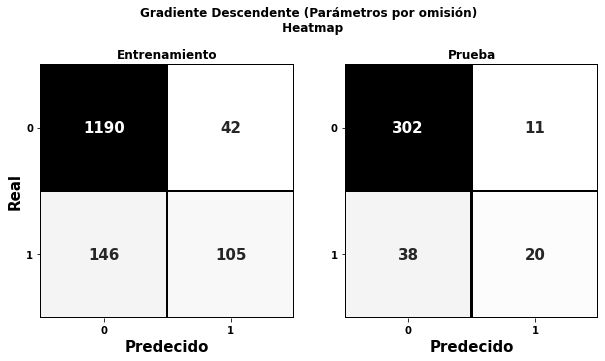

In [10]:
PlotHM(y_train, y_train_pred_GD, y_test, y_test_pred_GD, )

###### Curvas ROC y PR

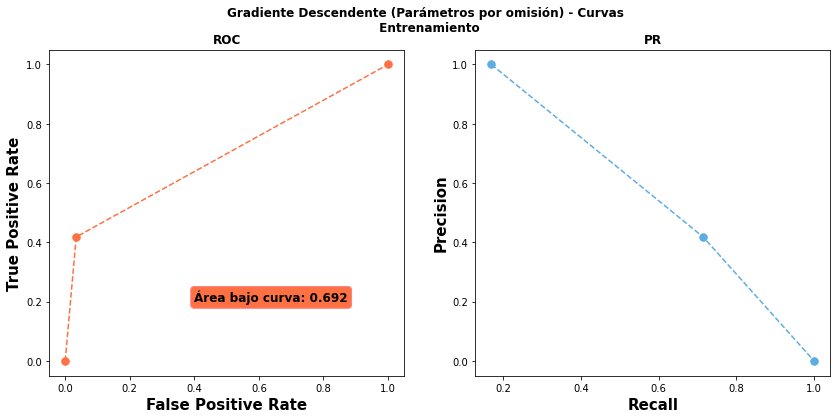

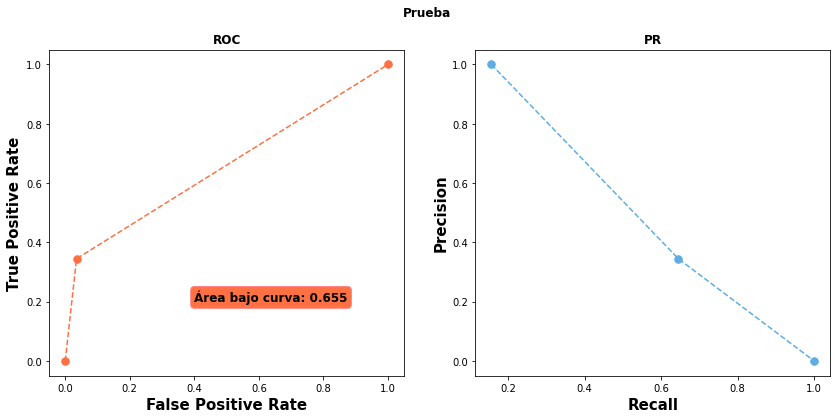

In [11]:
PlotCurves(y_train, y_train_pred_GD, Title='Gradiente Descendente (Parámetros por omisión) - Curvas \n Entrenamiento')
PlotCurves(y_test, y_test_pred_GD, Title='Prueba')

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

#### Clasificador

In [12]:
GD2 = SGDClassifier(random_state=0, penalty='elasticnet')

#### Grilla

In [13]:
param_grid_GD2 = [
  {'learning_rate': ['constant', 'adaptive'],
          'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'],
          'l1_ratio': list(np.linspace(0, 1, 11))+[0.15], #Para que exista el Default
          'alpha': np.logspace(-5, 0, 6),
          'eta0': np.logspace(-5, 0, 6)
          },
  {'learning_rate': ['optimal'],
          'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'],
          'l1_ratio': list(np.linspace(0, 1, 11))+[0.15], #Para que exista el Default
          'alpha': np.logspace(-5, 0, 6),
          'eta0': [0] #No utilizado al ser Optimal
          }
]

# #Para ver la grilla
# from sklearn.model_selection import ParameterGrid
# for params in ParameterGrid(param_grid_GD2):
#     print(params)

#### Búsqueda

In [14]:
GSCV = GridSearchCV(GD2, param_grid_GD2, cv=5, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'], refit=False, n_jobs=-1) #n_jobs es paralelizar
GSCV.fit(X_train, y_train);

#### Resultados

In [15]:
#Pasamos a DF los Resultados
Res_GSCV = pd.DataFrame(GSCV.cv_results_)

#Nos quedamos con las columnas que nos interesan
Res_GSCV = Res_GSCV[['param_alpha', 'param_eta0', 'param_l1_ratio', 'param_learning_rate',
       'param_loss', 'params', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy',
       'mean_test_precision_weighted', 'std_test_precision_weighted','rank_test_precision_weighted', 
       'mean_test_recall_weighted', 'std_test_recall_weighted', 'rank_test_recall_weighted',
       'mean_test_f1_weighted', 'std_test_f1_weighted', 'rank_test_f1_weighted']]

#Renombramos columnas (más amenas)
Res_GSCV.columns = ['Alpha', 'Eta0', 'L1_ratio', 'Learning_rate',
       'Loss', 'Params', 'Mean_accuracy', 'Std_accuracy', 'Rank_accuracy',
       'Mean_precision', 'Std_precision','Rank_precision', 
       'Mean_recall', 'Std_recall', 'Rank_recall',
       'Mean_f1', 'Std_f1', 'Rank_f1']

#Añadimos una columna con el promedio de ranking entre las 4 métricas
Res_GSCV['Mean_overall'] = Res_GSCV.eval('(Mean_accuracy + Mean_precision + Mean_recall + Mean_f1)*0.25')
Res_GSCV['Rank_overall'] = Res_GSCV.Mean_overall.rank(method='min', ascending=False).astype(int)

#Veamos la tabla ordenada
display(Res_GSCV.sort_values(['Rank_overall']))

,Alpha,Eta0,L1_ratio,Learning_rate,Loss,Params,Mean_accuracy,Std_accuracy,Rank_accuracy,Mean_precision,Std_precision,Rank_precision,Mean_recall,Std_recall,Rank_recall,Mean_f1,Std_f1,Rank_f1,Mean_overall,Rank_overall
2212,0.01,1,0,adaptive,hinge,"{'alpha': 0.01, 'eta0': 1.0, 'l1_ratio': 0.0, ...",0.871210,0.008851,1,0.876941,0.014737,1,0.871210,0.008851,1,0.839697,0.012817,424,0.864764,1
1660,0.001,1,0.3,adaptive,hinge,"{'alpha': 0.001, 'eta0': 1.0, 'l1_ratio': 0.30...",0.871208,0.009139,2,0.875171,0.016332,6,0.871208,0.009139,2,0.840317,0.012729,314,0.864476,2
1668,0.001,1,0.4,adaptive,hinge,"{'alpha': 0.001, 'eta0': 1.0, 'l1_ratio': 0.4,...",0.871208,0.009139,2,0.875171,0.016332,6,0.871208,0.009139,2,0.840317,0.012729,314,0.864476,2
1572,0.001,0.1,0.4,adaptive,hinge,"{'alpha': 0.001, 'eta0': 0.1, 'l1_ratio': 0.4,...",0.871208,0.009139,2,0.875171,0.016332,6,0.871208,0.009139,2,0.840317,0.012729,314,0.864476,2
1676,0.001,1,0.5,adaptive,hinge,"{'alpha': 0.001, 'eta0': 1.0, 'l1_ratio': 0.5,...",0.871208,0.009139,2,0.875171,0.016332,6,0.871208,0.009139,2,0.840317,0.012729,314,0.864476,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,1,1,0.15,constant,modified_huber,"{'alpha': 1.0, 'eta0': 1.0, 'l1_ratio': 0.15, ...",0.685927,0.259834,3739,0.573400,0.274327,3741,0.685927,0.259834,3739,0.615780,0.283712,3739,0.640258,3740
3378,1,1,0.2,constant,modified_huber,"{'alpha': 1.0, 'eta0': 1.0, 'l1_ratio': 0.2, '...",0.685927,0.259834,3739,0.573400,0.274327,3741,0.685927,0.259834,3739,0.615780,0.283712,3739,0.640258,3740
3379,1,1,0.2,constant,squared_hinge,"{'alpha': 1.0, 'eta0': 1.0, 'l1_ratio': 0.2, '...",0.604270,0.244048,3743,0.683960,0.083953,3738,0.604270,0.244048,3743,0.576361,0.255033,3743,0.617215,3742
3363,1,1,0,constant,squared_hinge,"{'alpha': 1.0, 'eta0': 1.0, 'l1_ratio': 0.0, '...",0.640331,0.245389,3741,0.587364,0.281561,3739,0.640331,0.245389,3741,0.597365,0.275324,3742,0.616348,3743


In [16]:
##Por si queremos ver dónde quedó el GD con parámetros Default...
display(Res_GSCV.query("Alpha==0.0001 and L1_ratio==0.15 and Learning_rate=='optimal' and Loss=='hinge'").T)

,3548
Alpha,0.0001
Eta0,0
L1_ratio,0.15
Learning_rate,optimal
Loss,hinge
Params,"{'alpha': 0.0001, 'eta0': 0, 'l1_ratio': 0.15,..."
Mean_accuracy,0.838179
Std_accuracy,0.0160954
Rank_accuracy,2686
Mean_precision,0.815312


#### Selección

In [17]:
#El mejor por cada ranking.
##Guardamos parámetros
GSVC_ac = Res_GSCV.loc[Res_GSCV.Rank_accuracy.idxmin()]
GSVC_pr = Res_GSCV.loc[Res_GSCV.Rank_precision.idxmin()]
GSVC_re = Res_GSCV.loc[Res_GSCV.Rank_recall.idxmin()]
GSVC_f1 = Res_GSCV.loc[Res_GSCV.Rank_f1.idxmin()]
GSVC_ov = Res_GSCV.loc[Res_GSCV.Rank_overall.idxmin()]
print('Parámetros (y puntaje correspondiente) del mejor modelo según performance en:'
      '\n Accuracy  {:.3f}: {}\n Precision {:.3f}: {}\n Recall    {:.3f}: {}'
      '\n F1-Score  {:.3f}: {}\n Overall   {:.3f}: {}\n'.format(
          GSVC_ac.Mean_accuracy, GSVC_ac.Params,
          GSVC_pr.Mean_precision, GSVC_pr.Params,
          GSVC_re.Mean_recall, GSVC_re.Params,
          GSVC_f1.Mean_f1, GSVC_f1.Params,
          GSVC_ov.Mean_overall, GSVC_ov.Params))

#Checkeamos iguales
Equal = 0
All   = [GSVC_ac.Params, GSVC_pr.Params, GSVC_re.Params, GSVC_f1.Params, GSVC_ov.Params]
for a in range(5):
    for b in range(a+1,5):
        if All[a]==All[b]:
            Equal+=1
            print('Modelo {} == Modelo {}'.format(a, b))

Parámetros (y puntaje correspondiente) del mejor modelo según performance en:
 Accuracy  0.871: {'alpha': 0.01, 'eta0': 1.0, 'l1_ratio': 0.0, 'learning_rate': 'adaptive', 'loss': 'hinge'}
 Precision 0.877: {'alpha': 0.01, 'eta0': 1.0, 'l1_ratio': 0.0, 'learning_rate': 'adaptive', 'loss': 'hinge'}
 Recall    0.871: {'alpha': 0.01, 'eta0': 1.0, 'l1_ratio': 0.0, 'learning_rate': 'adaptive', 'loss': 'hinge'}
 F1-Score  0.850: {'alpha': 0.0001, 'eta0': 0, 'l1_ratio': 0.9, 'learning_rate': 'optimal', 'loss': 'hinge'}
 Overall   0.865: {'alpha': 0.01, 'eta0': 1.0, 'l1_ratio': 0.0, 'learning_rate': 'adaptive', 'loss': 'hinge'}

Modelo 0 == Modelo 1
Modelo 0 == Modelo 2
Modelo 0 == Modelo 4
Modelo 1 == Modelo 2
Modelo 1 == Modelo 4
Modelo 2 == Modelo 4


**Detalle**: De los 5 modelos según métricas, 4 son el mismo. (Obtuvo el 1er lugar en _Accuracy_, _Precision_ y _F1-Score_, y por lo tanto posee también mejor _Overall_)

#### Clasificadores 2.0

Debido a que analizamos varias métricas, ``GridSearchCV`` no _almacena_ un _mejor_ modelo; por ello re-fitteamos los modelos.

In [18]:
print('Debido a que algunos modelos pueden ser iguales, analizaremos %i modelos.' %(5 - Equal/2))

Debido a que algunos modelos pueden ser iguales, analizaremos 2 modelos.


In [19]:
GD2_ac = SGDClassifier(**GSVC_ac.Params, random_state=0, penalty='elasticnet')
GD2_pr = SGDClassifier(**GSVC_pr.Params, random_state=0, penalty='elasticnet')
GD2_re = SGDClassifier(**GSVC_re.Params, random_state=0, penalty='elasticnet')
GD2_f1 = SGDClassifier(**GSVC_f1.Params, random_state=0, penalty='elasticnet')
GD2_ov = SGDClassifier(**GSVC_ov.Params, random_state=0, penalty='elasticnet')

#### Entrenamiento

In [20]:
GD2_ac.fit(X_train, y_train);
GD2_pr.fit(X_train, y_train);
GD2_re.fit(X_train, y_train);
GD2_f1.fit(X_train, y_train);
GD2_ov.fit(X_train, y_train);

#### Predicción

In [21]:
y_train_pred_GD2_ac = GD2_ac.predict(X_train)
y_test_pred_GD2_ac  = GD2_ac.predict(X_test)

y_train_pred_GD2_pr = GD2_pr.predict(X_train)
y_test_pred_GD2_pr  = GD2_pr.predict(X_test)

y_train_pred_GD2_re = GD2_re.predict(X_train)
y_test_pred_GD2_re  = GD2_re.predict(X_test)

y_train_pred_GD2_f1 = GD2_f1.predict(X_train)
y_test_pred_GD2_f1  = GD2_f1.predict(X_test)

y_train_pred_GD2_ov = GD2_ov.predict(X_train)
y_test_pred_GD2_ov  = GD2_ov.predict(X_test)

#### Plots

##### Matrix de confusión

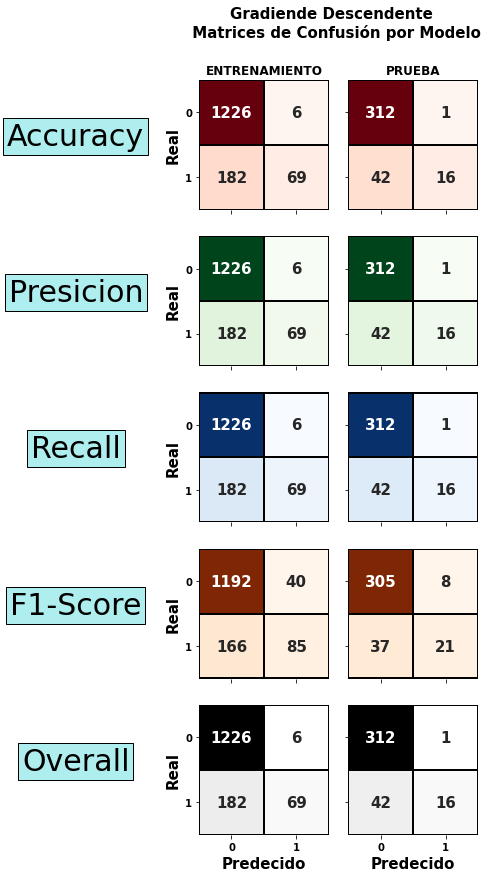

In [22]:
Plot5HM(y_train, y_train_pred_GD2_ac, y_train_pred_GD2_pr, y_train_pred_GD2_re, y_train_pred_GD2_f1, y_train_pred_GD2_ov,
        y_test, y_test_pred_GD2_ac, y_test_pred_GD2_pr, y_test_pred_GD2_re, y_test_pred_GD2_f1, y_test_pred_GD2_ov, 'Gradiende Descendente')

##### Curvas ROC y PR

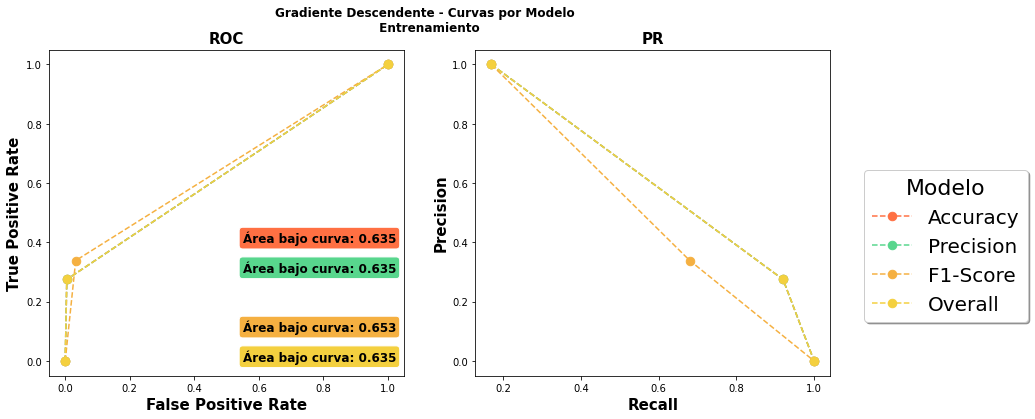

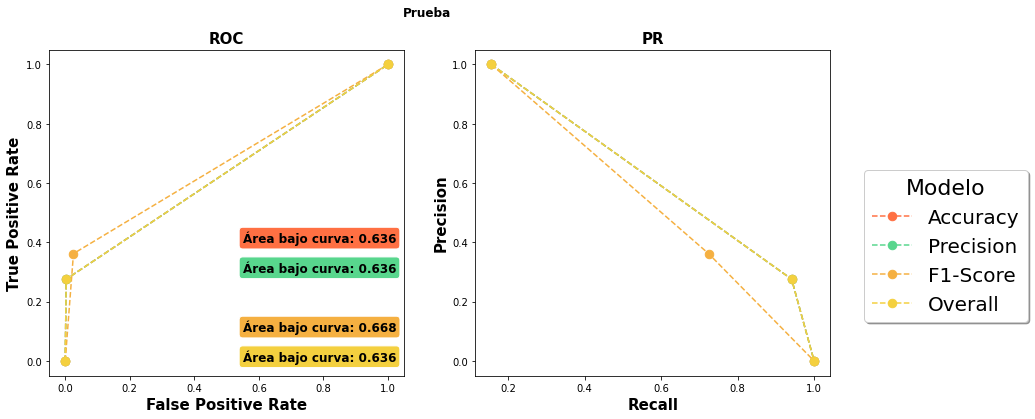

In [23]:
Plot5Curves(y_train, y_test, 
                y_train_ac=y_train_pred_GD2_ac, y_train_pr=y_train_pred_GD2_pr, y_train_f1=y_train_pred_GD2_f1, y_train_ov=y_train_pred_GD2_ov,
                y_test_ac=y_test_pred_GD2_ac, y_test_pr=y_test_pred_GD2_pr, y_test_f1=y_test_pred_GD2_f1, y_test_ov=y_test_pred_GD2_ov,
                title='Gradiente Descendente')

## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

#### Clasificador

In [24]:
DTC = DecisionTreeClassifier(random_state=0)

print('Parámetros utilizados: \n', np.array(list(DTC.get_params(deep=False).items())))

Parámetros utilizados: 
 [['ccp_alpha' 0.0]
 ['class_weight' None]
 ['criterion' 'gini']
 ['max_depth' None]
 ['max_features' None]
 ['max_leaf_nodes' None]
 ['min_impurity_decrease' 0.0]
 ['min_impurity_split' None]
 ['min_samples_leaf' 1]
 ['min_samples_split' 2]
 ['min_weight_fraction_leaf' 0.0]
 ['presort' 'deprecated']
 ['random_state' 0]
 ['splitter' 'best']]


#### Entrenamiento

In [25]:
DTC.fit(X_train, y_train);

#### Predicción

In [26]:
y_train_pred_DTC = DTC.predict(X_train)
y_test_pred_DTC  = DTC.predict(X_test)

#### Árbol

In [27]:
print('Profundidad máxima:', DTC.get_depth())
print('Cantida de hojas  :', DTC.get_n_leaves())

Profundidad máxima: 22
Cantida de hojas  : 141


##### Inicios

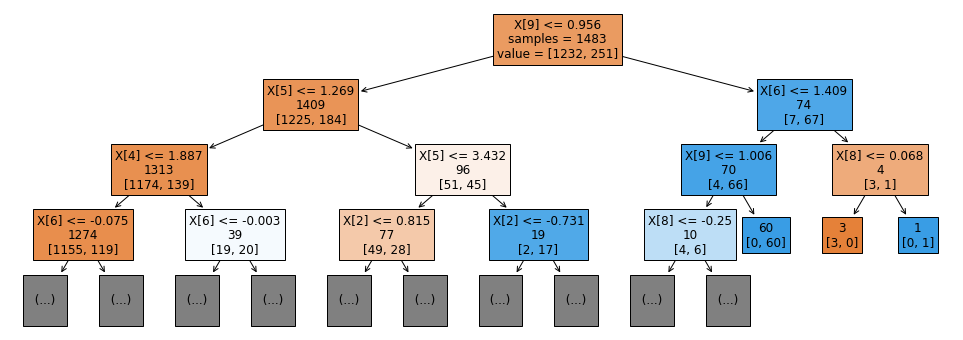

In [28]:
plt.figure(figsize=(17,6))
plot_tree(DTC, impurity=False, filled=True, max_depth=3, fontsize=12, label='root')
plt.show()

##### Total

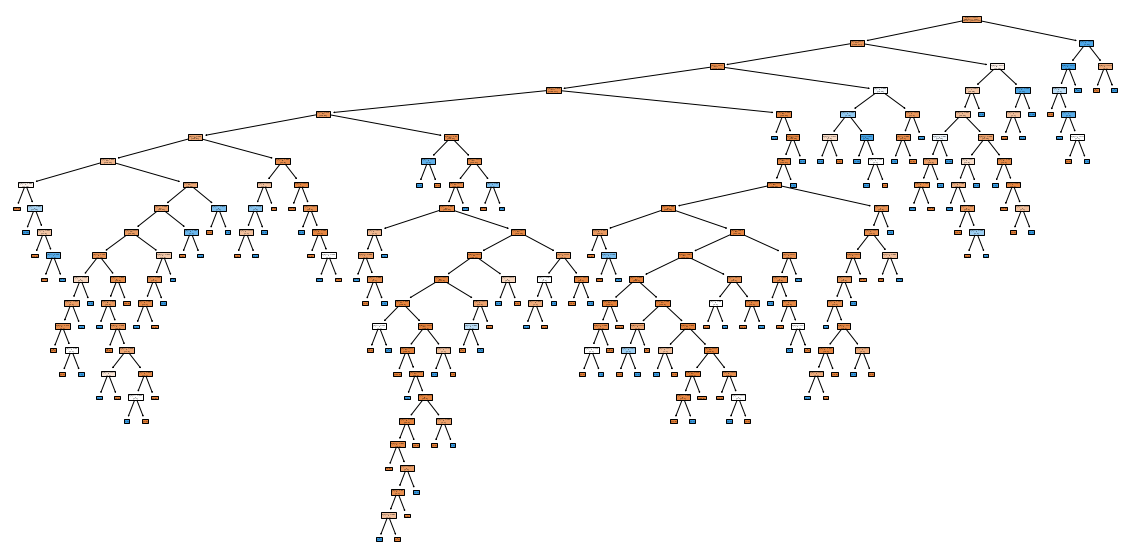

In [29]:
plt.figure(figsize=(20,10))
plot_tree(DTC, impurity=False, filled=True, label='root')
plt.show()

#### Métricas

In [30]:
print('------------------------------------------------------------')
Metrics(y_train, y_train_pred_DTC)
print('------------------------------------------------------------')
Metrics(y_test, y_test_pred_DTC, 'Prueba')
print('------------------------------------------------------------')

------------------------------------------------------------
Métricas Entrenamiento:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000      1232
           1      1.000     1.000     1.000       251

    accuracy                          1.000      1483
   macro avg      1.000     1.000     1.000      1483
weighted avg      1.000     1.000     1.000      1483

 Confusion Matrix: 
[[1232    0]
 [   0  251]]
------------------------------------------------------------
Métricas Prueba:
               precision    recall  f1-score   support

           0      0.932     0.927     0.929       313
           1      0.617     0.638     0.627        58

    accuracy                          0.881       371
   macro avg      0.775     0.782     0.778       371
weighted avg      0.883     0.881     0.882       371

 Confusion Matrix: 
[[290  23]
 [ 21  37]]
------------------------------------------------------------


##### Plots

###### Matrix de confusión

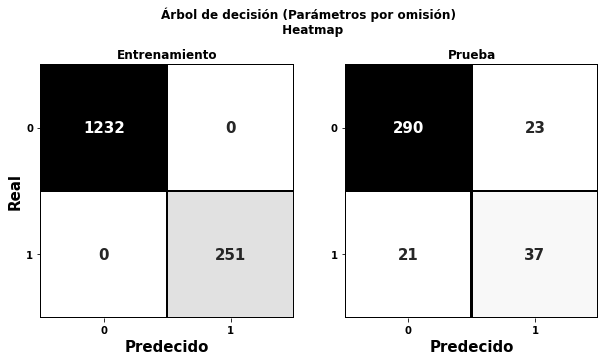

In [31]:
PlotHM(y_train, y_train_pred_DTC, y_test, y_test_pred_DTC, Title='Árbol de decisión (Parámetros por omisión) \n Heatmap')

###### Curvas ROC y PR

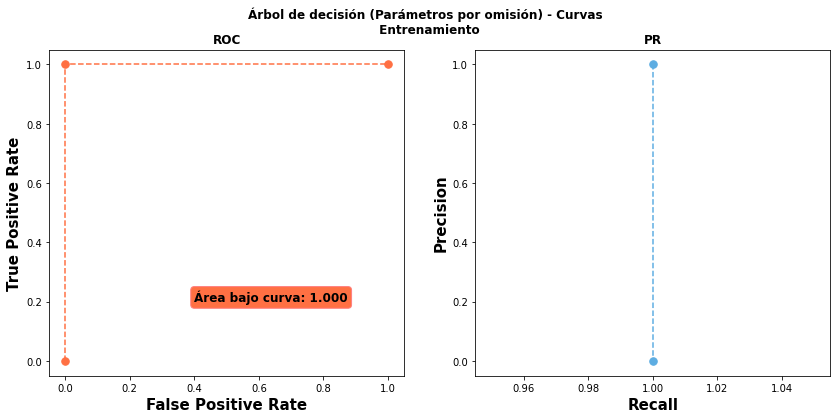

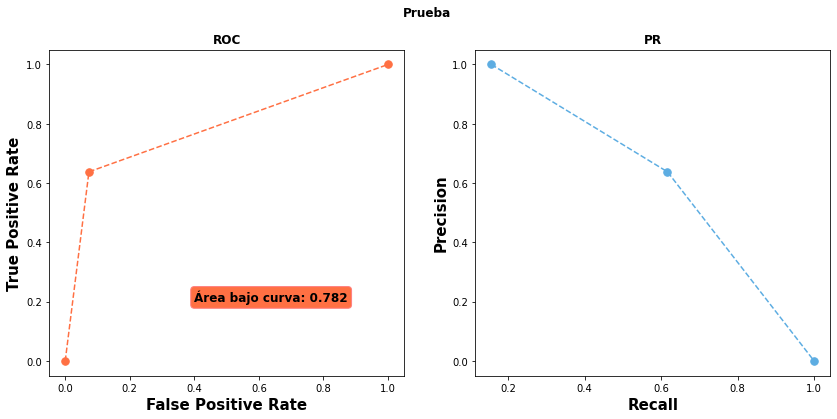

In [32]:
PlotCurves(y_train, y_train_pred_DTC, Title='Árbol de decisión (Parámetros por omisión) - Curvas \n Entrenamiento')
PlotCurves(y_test, y_test_pred_DTC, Title='Prueba')

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

#### Clasificador

In [33]:
DTC2 = DecisionTreeClassifier(random_state=0)

#### Grilla

In [34]:
param_grid_DTC2 = [
  {'splitter': ['best'],
          'criterion': ['gini', 'entropy'],
          'max_depth': list(np.arange(4,24,2))+[None],
          'min_samples_leaf': np.arange(1,10),
          'min_samples_split': np.arange(2,10),
          'max_features': [None, 'sqrt', 'log2']
          },
  {'splitter': ['random'],
          'criterion': ['gini', 'entropy'],
          'max_depth': list(np.arange(4,24,2))+[None],
          'min_samples_leaf': np.arange(1,10),
          'min_samples_split': np.arange(2,10)
          }
]

##Para ver la grilla
#from sklearn.model_selection import ParameterGrid
#for params in ParameterGrid(param_grid_DTC2):
    #print(params)

#### Búsqueda

In [35]:
GSCV2 = GridSearchCV(DTC2, param_grid_DTC2, cv=5, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'], refit=False, n_jobs=-1) #n_jobs es paralelizar
GSCV2.fit(X_train, y_train);

#### Resultados

In [36]:
#Pasamos a DF los Resultados
Res_GSCV2 = pd.DataFrame(GSCV2.cv_results_)

#Nos quedamos con las columnas que nos interesan
Res_GSCV2 = Res_GSCV2[['param_criterion', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf',
       'param_min_samples_split', 'param_splitter', 'params', 'mean_test_accuracy',
       'std_test_accuracy', 'rank_test_accuracy','mean_test_precision_weighted',
       'std_test_precision_weighted','rank_test_precision_weighted', 'mean_test_recall_weighted', 'std_test_recall_weighted',
       'rank_test_recall_weighted', 'mean_test_f1_weighted', 'std_test_f1_weighted', 'rank_test_f1_weighted']]

#Renombramos columnas (más amenas)
Res_GSCV2.columns = ['Criterion', 'Max_depth', 'Max_features', 'Min_samples_leaf', 'Min_samples_split',
       'Splitter', 'Params', 'Mean_accuracy', 'Std_accuracy', 'Rank_accuracy',
       'Mean_precision', 'Std_precision','Rank_precision', 
       'Mean_recall', 'Std_recall', 'Rank_recall',
       'Mean_f1', 'Std_f1', 'Rank_f1']

#Añadimos una columna con el promedio de ranking entre las 4 métricas
Res_GSCV2['Mean_overall'] = Res_GSCV2.eval('(Mean_accuracy + Mean_precision + Mean_recall + Mean_f1)*0.25')
Res_GSCV2['Rank_overall'] = Res_GSCV2.Mean_overall.rank(method='min', ascending=False).astype(int)

#Veamos la tabla ordenada
display(Res_GSCV2.sort_values(['Rank_overall']))

,Criterion,Max_depth,Max_features,Min_samples_leaf,Min_samples_split,Splitter,Params,Mean_accuracy,Std_accuracy,Rank_accuracy,Mean_precision,Std_precision,Rank_precision,Mean_recall,Std_recall,Rank_recall,Mean_f1,Std_f1,Rank_f1,Mean_overall,Rank_overall
3602,entropy,14,log2,1,4,best,"{'criterion': 'entropy', 'max_depth': 14, 'max...",0.886027,0.017197,1,0.879626,0.018520,35,0.886027,0.017197,1,0.881013,0.017344,1,0.883173,1
3530,entropy,14,sqrt,1,4,best,"{'criterion': 'entropy', 'max_depth': 14, 'max...",0.886027,0.017197,1,0.879626,0.018520,35,0.886027,0.017197,1,0.881013,0.017344,1,0.883173,1
720,gini,10,sqrt,1,2,best,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.885385,0.011707,3,0.879639,0.019456,33,0.885385,0.011707,3,0.873481,0.009586,33,0.880973,3
792,gini,10,log2,1,2,best,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.885385,0.011707,3,0.879639,0.019456,33,0.885385,0.011707,3,0.873481,0.009586,33,0.880973,3
5185,gini,16,NaN,1,3,random,"{'criterion': 'gini', 'max_depth': 16, 'min_sa...",0.884011,0.021623,6,0.876859,0.025701,103,0.884011,0.021623,6,0.877309,0.022209,3,0.880548,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6156,entropy,20,NaN,5,6,random,"{'criterion': 'entropy', 'max_depth': 20, 'min...",0.838168,0.013963,6329,0.824927,0.015871,6329,0.838168,0.013963,6329,0.829101,0.014496,6241,0.832591,6329
6155,entropy,20,NaN,5,5,random,"{'criterion': 'entropy', 'max_depth': 20, 'min...",0.838168,0.013963,6329,0.824927,0.015871,6329,0.838168,0.013963,6329,0.829101,0.014496,6241,0.832591,6329
6154,entropy,20,NaN,5,4,random,"{'criterion': 'entropy', 'max_depth': 20, 'min...",0.838168,0.013963,6329,0.824927,0.015871,6329,0.838168,0.013963,6329,0.829101,0.014496,6241,0.832591,6329
6153,entropy,20,NaN,5,3,random,"{'criterion': 'entropy', 'max_depth': 20, 'min...",0.838168,0.013963,6329,0.824927,0.015871,6329,0.838168,0.013963,6329,0.829101,0.014496,6241,0.832591,6329


#### Selección

In [37]:
##Por si queremos ver dónde quedó el árbol con parámetros Default...
display(Res_GSCV2.query("Criterion=='gini' and Min_samples_split==2 and Min_samples_leaf==1 and Splitter=='best' and Max_depth in [None] and Max_features in [None]").T)

,2160
Criterion,gini
Max_depth,None
Max_features,None
Min_samples_leaf,1
Min_samples_split,2
Splitter,best
Params,"{'criterion': 'gini', 'max_depth': None, 'max_..."
Mean_accuracy,0.85099
Std_accuracy,0.0189104
Rank_accuracy,5859


In [38]:
#El mejor por cada ranking.
##Guardamos parámetros
GSVC2_ac = Res_GSCV2.loc[Res_GSCV2.Rank_accuracy.idxmin()]
GSVC2_pr = Res_GSCV2.loc[Res_GSCV2.Rank_precision.idxmin()]
GSVC2_re = Res_GSCV2.loc[Res_GSCV2.Rank_recall.idxmin()]
GSVC2_f1 = Res_GSCV2.loc[Res_GSCV2.Rank_f1.idxmin()]
GSVC2_ov = Res_GSCV2.loc[Res_GSCV2.Rank_overall.idxmin()]
print('Parámetros (y puntaje correspondiente) del mejor modelo según performance en:'
      '\n Accuracy  {:.3f}: {}\n Precision {:.3f}: {}\n Recall    {:.3f}: {}'
      '\n F1-Score  {:.3f}: {}\n Overall   {:.3f}: {}\n'.format(
          GSVC2_ac.Mean_accuracy, GSVC2_ac.Params,
          GSVC2_pr.Mean_precision, GSVC2_pr.Params,
          GSVC2_re.Mean_recall, GSVC2_re.Params,
          GSVC2_f1.Mean_f1, GSVC2_f1.Params,
          GSVC2_ov.Mean_overall, GSVC2_ov.Params))

#Checkeamos iguales
Equal2 = 0
All2   = [GSVC2_ac.Params, GSVC2_pr.Params, GSVC2_re.Params, GSVC2_f1.Params, GSVC2_ov.Params]
for a in range(5):
    for b in range(a+1,5):
        if All2[a]==All2[b]:
            Equal2 +=1
            print('Modelo {} == Modelo {}'.format(a, b))

Parámetros (y puntaje correspondiente) del mejor modelo según performance en:
 Accuracy  0.886: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'best'}
 Precision 0.880: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
 Recall    0.886: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'best'}
 F1-Score  0.881: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'best'}
 Overall   0.883: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'best'}

Modelo 0 == Modelo 2
Modelo 0 == Modelo 3
Modelo 0 == Modelo 4
Modelo 2 == Modelo 3
Modelo 2 == Modelo 4
Modelo 3 == Modelo 4


**Detalle:** De los 5 modelos según métricas, 4 son el mismo. (Obtuvo el  1<sup>er</sup> lugar en _Accuracy_, _Recall_ y _F1-Score_, y por lo tanto posee también mejor _Overall_)

#### Clasificadores 2.0

Debido a que analizamos varias métricas, ``GridSearchCV`` no _almacena_ un _mejor_ modelo; por ello re-fittearemos los modelos.

Cada modelo tendrá el nombre de su _métrica_.

In [39]:
print('Debido a que algunos modelos pueden ser iguales, analizaremos %i modelos.' %(5 - Equal2/2))

Debido a que algunos modelos pueden ser iguales, analizaremos 2 modelos.


In [40]:
DTC2_ac = DecisionTreeClassifier(**GSVC2_ac.Params, random_state=0)
DTC2_pr = DecisionTreeClassifier(**GSVC2_pr.Params, random_state=0)
DTC2_re = DecisionTreeClassifier(**GSVC2_re.Params, random_state=0)
DTC2_f1 = DecisionTreeClassifier(**GSVC2_f1.Params, random_state=0)
DTC2_ov = DecisionTreeClassifier(**GSVC2_ov.Params, random_state=0)

#### Entrenamiento

In [41]:
DTC2_ac.fit(X_train, y_train);
DTC2_pr.fit(X_train, y_train);
DTC2_re.fit(X_train, y_train);
DTC2_f1.fit(X_train, y_train);
DTC2_ov.fit(X_train, y_train);

#### Predicción

In [42]:
y_train_pred_DTC2_ac = DTC2_ac.predict(X_train)
y_test_pred_DTC2_ac  = DTC2_ac.predict(X_test)

y_train_pred_DTC2_pr = DTC2_pr.predict(X_train)
y_test_pred_DTC2_pr  = DTC2_pr.predict(X_test)

y_train_pred_DTC2_re = DTC2_re.predict(X_train)
y_test_pred_DTC2_re  = DTC2_re.predict(X_test)

y_train_pred_DTC2_f1 = DTC2_f1.predict(X_train)
y_test_pred_DTC2_f1  = DTC2_f1.predict(X_test)

y_train_pred_DTC2_ov = DTC2_ov.predict(X_train)
y_test_pred_DTC2_ov  = DTC2_ov.predict(X_test)

#### Árboles

##### Inicios

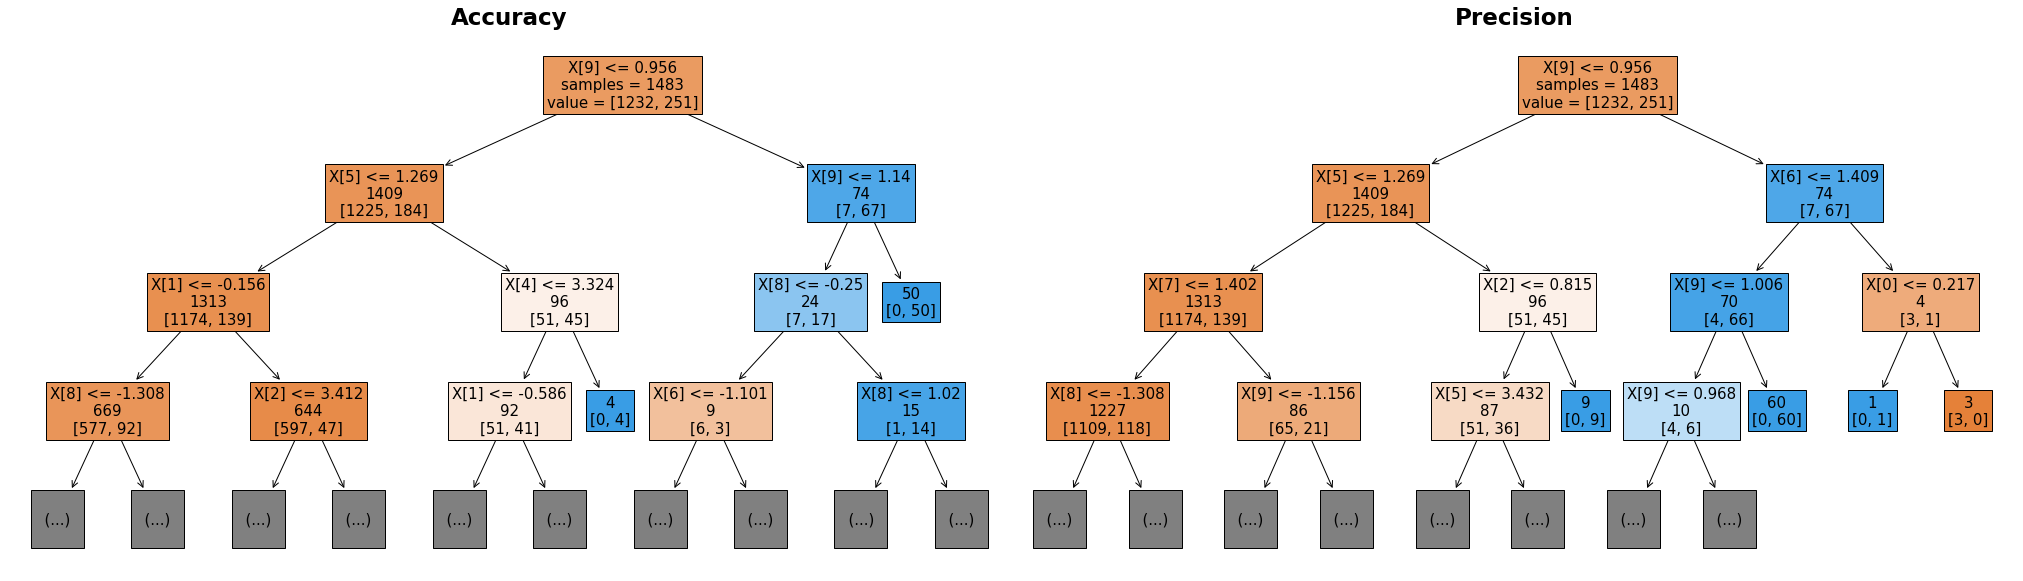

In [43]:
fig, ax = plt.subplots(1,2, figsize=(36,10), sharey=True)
plt.subplots_adjust(wspace=0)
plt.title('Árboles')
plot_tree(DTC2_ac, ax=ax[0], impurity=False, max_depth=3, fontsize=15,
          filled=True, label='root')
plot_tree(DTC2_pr, ax=ax[1], impurity=False, max_depth=3, fontsize=15,
          filled=True, label='root')
ax[0].set_title('Accuracy', size=23)
ax[1].set_title('Precision', size=23)
plt.show()

##### Totales

-----------------------------------
Profundidad máxima según métrica:
 Accuracy : 14
 Precision: 4
-----------------------------------
Cantida de hojas según métrica:
 Accuracy : 121
 Precision: 12
-----------------------------------


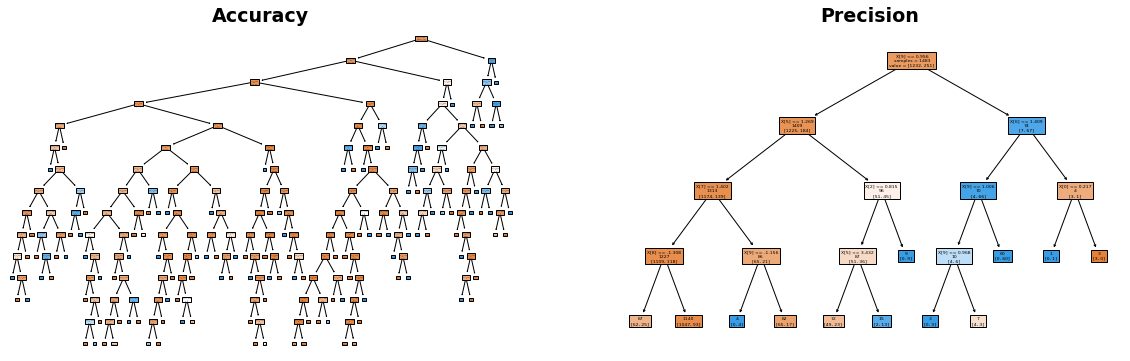

In [44]:
print('-----------------------------------')
print('Profundidad máxima según métrica:'
      '\n Accuracy : {}'
      '\n Precision: {}'
      .format(
          DTC2_ac.get_depth(),
          DTC2_pr.get_depth()
      ))
print('-----------------------------------')
print('Cantida de hojas según métrica:'
      '\n Accuracy : {}'
      '\n Precision: {}'
      .format(
          DTC2_ac.get_n_leaves(),
          DTC2_pr.get_n_leaves()
      ))
print('-----------------------------------')

fig, ax = plt.subplots(1,2, figsize=(20,6))
plt.title('Árboles')
plot_tree(DTC2_ac, ax=ax[0], impurity=False, filled=True, label='root')
plot_tree(DTC2_pr, ax=ax[1], impurity=False, filled=True, label='root')
ax[0].set_title('Accuracy', size=19)
ax[1].set_title('Precision', size=19)
plt.show()

#### Plots

##### Matrix de confusión

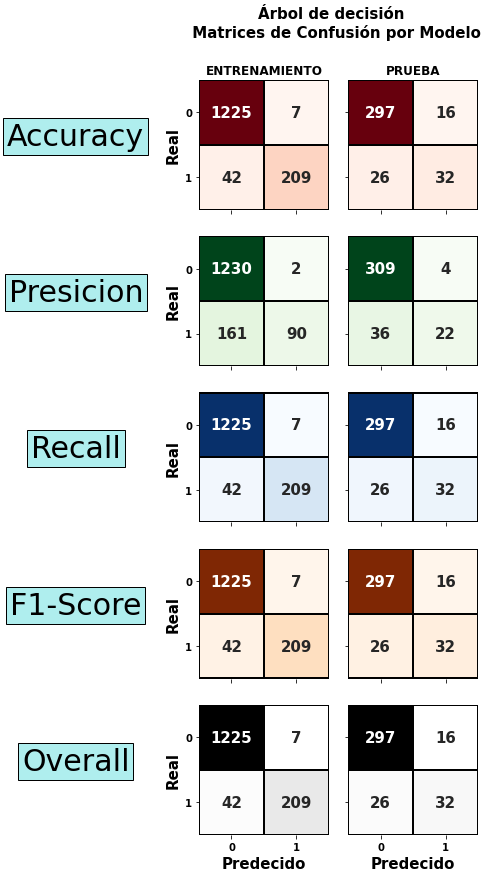

In [45]:
Plot5HM(y_train, y_train_pred_DTC2_ac, y_train_pred_DTC2_pr, y_train_pred_DTC2_re, y_train_pred_DTC2_f1, y_train_pred_DTC2_ov,
        y_test, y_test_pred_DTC2_ac, y_test_pred_DTC2_pr, y_test_pred_DTC2_re, y_test_pred_DTC2_f1, y_test_pred_DTC2_ov)

##### Curvas ROC y PR

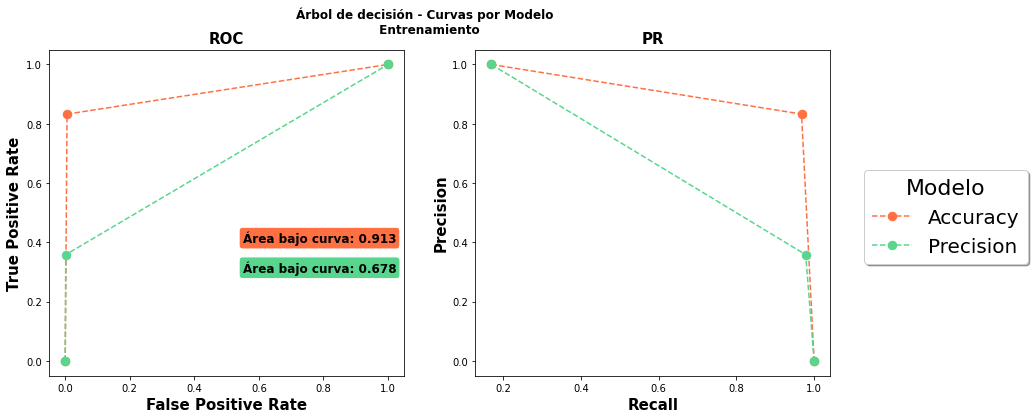

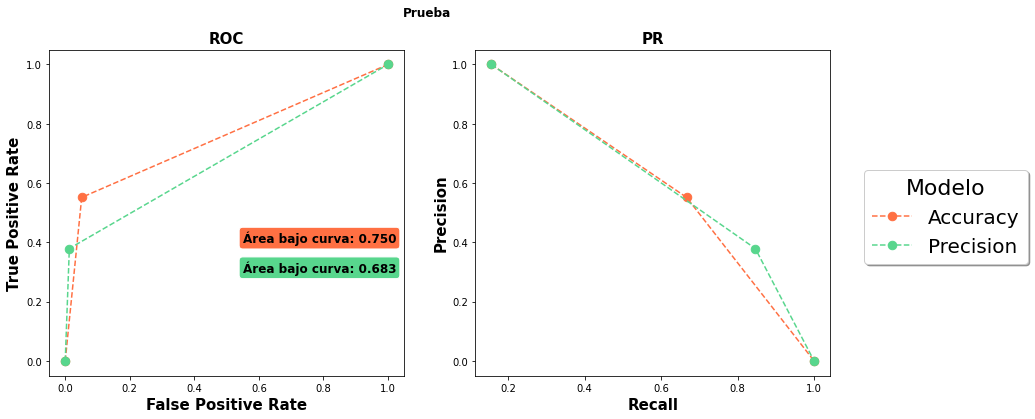

In [46]:
Plot5Curves(y_train, y_test, 
                y_train_ac=y_train_pred_DTC2_ac, y_train_pr=y_train_pred_DTC2_pr,
                y_test_ac=y_test_pred_DTC2_ac, y_test_pr=y_test_pred_DTC2_pr,
                title='Árbol de decisión')

# Conclusión

En base a los resultados generados, podemos concluir que los modelos basados en árboles de decisión poseen mejor desempeño respecto a la contraparte del gradiente descendente. 

Desde la perspectiva de negocio resulta prioritario elegir un modelo con la capacidad de anticipar los defaults sobre los prestamos otorgados en función del costo que pueda representar para la institución. Por ello nos quedamos con el modelo de mayor _recall_ que minimiza la pérdidad de capital.